# Homework 6

In [80]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

import xgboost


/opt/miniconda3/envs/ml-zoomcamp/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [15]:
df = pd.read_csv('data/data.csv')

# Only use the following columns.
columns = ['latitude', 'longitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'ocean_proximity']
df = df[columns]

# Fill NAs with 0.
df = df.fillna(value=0)

# Apply the log tranform to median_house_value.
df.median_house_value = np.log1p(df.median_house_value)

# Do train/validation/test split with 60%/20%/20% distribution.
train_full, test = train_test_split(df, test_size=0.2, random_state=1)
train, val = train_test_split(train_full, test_size=0.25, random_state=1)

train = train.reset_index(drop=True)
y_train = train.median_house_value
del train['median_house_value']

val = val.reset_index(drop=True)
y_val = val.median_house_value
del val['median_house_value']

test = test.reset_index(drop=True)
y_test = test.median_house_value
del test['median_house_value']

# Use DictVectorizer to turn the dataframe into matrices.
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train.to_dict(orient='records'))
X_val = dv.transform(val.to_dict(orient='records'))
X_test = dv.transform(test.to_dict(orient='records'))


## Question 1


In [20]:
model = DecisionTreeRegressor(max_depth=1)
model.fit(X=X_train, y=y_train)

DecisionTreeRegressor(max_depth=1)

In [25]:
print(export_text(model, feature_names=dv.get_feature_names()))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



/opt/miniconda3/envs/ml-zoomcamp/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Question 2

In [28]:
model = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [33]:
preds_val = model.predict(X_val)

In [37]:
round(mean_squared_error(y_val, preds_val, squared=False), 2)

0.25

## Question 3

In [51]:
rmses = []
n_est = np.arange(10, 210, 10)

print(f"{'n_estimators' : >10} -> {'RMSE': <10}")
for n_trees in n_est:
    model = RandomForestRegressor(n_estimators=n_trees, random_state=1, n_jobs=-1)
    model.fit(X_train, y_train)
    
    preds_val = model.predict(X_val)
    rmse = round(mean_squared_error(y_val, preds_val, squared=False), 4)
    rmses.append(rmse)

    print(f"{n_trees : <10} -> {rmse : <10}")

n_estimators -> RMSE      
10         -> 0.2458    
20         -> 0.2392    
30         -> 0.2357    
40         -> 0.2345    
50         -> 0.2331    
60         -> 0.2329    
70         -> 0.2325    
80         -> 0.2326    
90         -> 0.2322    
100        -> 0.2319    
110        -> 0.2315    
120        -> 0.2316    
130        -> 0.2317    
140        -> 0.2317    
150        -> 0.2317    
160        -> 0.2317    
170        -> 0.2316    
180        -> 0.2318    
190        -> 0.2318    
200        -> 0.2317    


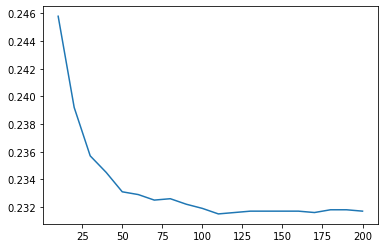

In [52]:
plt.plot(n_est, rmses)

## Question 4

In [57]:
results = []

max_depths = [10, 15, 20, 25]
n_est = np.arange(10, 210, 10)

for max_depth in max_depths:
    for n_trees in n_est:
        model = RandomForestRegressor(n_estimators=n_trees, max_depth=max_depth, random_state=1, n_jobs=-1)
        model.fit(X_train, y_train)

        preds_val = model.predict(X_val)
        rmse = round(mean_squared_error(y_val, preds_val, squared=False), 4)

        results.append({'max_depth': max_depth, 'n_estimators': n_trees, 'rmse': rmse})
        
results = pd.DataFrame.from_records(data=results)

In [58]:
results.sort_values(by='rmse')

,max_depth,n_estimators,rmse
70,25,110,0.2312
71,25,120,0.2312
73,25,140,0.2314
79,25,200,0.2314
76,25,170,0.2314
...,...,...,...
4,10,50,0.2501
3,10,40,0.2510
2,10,30,0.2515
1,10,20,0.2526


## Question 5

In [73]:
model = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1) 
model.fit(X_train, y_train)

importances = pd.DataFrame({'importances': model.feature_importances_, 'features': dv.get_feature_names_out()})
        

<AxesSubplot:xlabel='features'>

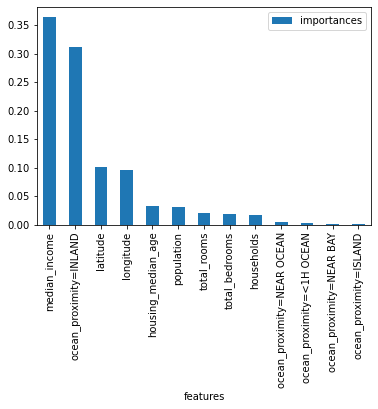

In [75]:
importances.sort_values(by='importances', ascending=False).plot.bar(x='features', y='importances')

## Question 6

In [120]:
# https://github.com/alexeygrigorev/mlbookcamp-code/blob/master/course-zoomcamp/06-trees/notebook.ipynb

def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [121]:
features = [feature.replace('<', 'smaller_then')for feature in dv.get_feature_names()]
dtrain = xgboost.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgboost.DMatrix(X_val, label=y_val, feature_names=features)

watchlist = [(dtrain, 'train'), (dval, 'val')]

/opt/miniconda3/envs/ml-zoomcamp/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### eta=0.3

In [122]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgboost.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

s = output.stdout

In [123]:
df_score = parse_xgb_output(output)
print(f'rmse: {round(df_score.val_rmse.max(), 2)}')

rmse: 8.13


### eta=0.1

In [124]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgboost.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

s = output.stdout

In [125]:
df_score = parse_xgb_output(output)
print(f'rmse: {round(df_score.val_rmse.max(), 2)}')

rmse: 10.45
